**Final report for Group "Null in my kernel" - Sverre Wiedswang, Sindre Lothe & Aaryan Neupane, student numbers 527797, 527791 & 563731, kaggle team name: Null in my kernel**

On blackboard we noticed we have joined different groups. We have been working together the whole project and been one group for the entire duration.

Our model here is a catboost model where 5 kfolds are used to cross validate and we combine this with an Autogluon model which gave us our best prediction.

# Imports and file handling

## Import files and set matplotlib params. Only change if you want new python packages

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold 

from catboost import CatBoostRegressor, Pool
import datetime


newparams = {'figure.figsize': (12, 8), 'axes.grid': False,
             'lines.linewidth': 2,
             'font.size': 15, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}

plt.rcParams.update(newparams)

## File handling

This part retrieves the from the provided file structure into one dataframe. This is made in order to be able to easily iterate through the dataframes later during feature engineering and merging in order to not have to do the same lines for each file and each site (3 times 3 = 9 times)

In [12]:
data_path=lambda f : f"../data/{f}/"

folders = ["A", "B", "C"]


dataframes = {f : {} for f in folders}
for folder in folders:
    for file in os.listdir(data_path(folder)):
        filename=file.split(".")[0]
        dataframes[folder][filename]=pd.read_parquet(data_path(folder)+ file)


# Pre processing

## Helpful functions

site_to_num functions in order to easily convert from site names to associated numbers. During the process the numbers have gone from 0, 1, 2 to 1, 2, 3, there may be some artefacts from the old system in the code. It is most safe to use site_to_num whenever this function is used.

merge_frames is a function made to convert the dataframes dictionary into a df containing all the relevant dataframes for training. The X frame used for submission is excluded. 

In [4]:
def site_to_num(site):
    if site not in ["A", "B", "C"]:
        raise Exception("site must be A, B or C")
    elif site=="A":
        return 1
    elif site=="B":
        return 2
    elif site=="C":
        return 3


def feature(train, train_weather):
    train["time1"] = train["time"] + pd.offsets.DateOffset(minutes=15)
    train["time2"] = train["time"] + pd.offsets.DateOffset(minutes=30)
    train["time3"] = train["time"] + pd.offsets.DateOffset(minutes=45)

    train_weather_0 = train_weather[train_weather["date_forecast"].isin(train["time"])].reset_index()
    train_weather_0 = train_weather_0.drop(columns=['index', 'date_forecast'])

    train_weather_1 = train_weather[train_weather['date_forecast'].isin(train['time1'])].reset_index()
    train_weather_1.columns = [key+'1' for key in train_weather_1.columns]
    train_weather_1 = train_weather_1.drop(columns=['index1', 'date_forecast1'])

    train_weather_2 = train_weather[train_weather['date_forecast'].isin(train['time2'])].reset_index()
    train_weather_2.columns = [key+'2' for key in train_weather_2.columns]
    train_weather_2 = train_weather_2.drop(columns=['index2', 'date_forecast2'])

    train_weather_3 = train_weather[train_weather['date_forecast'].isin(train['time3'])].reset_index()
    train_weather_3.columns = [key+'3' for key in train_weather_3.columns]
    train_weather_3 = train_weather_3.drop(columns=['index3', 'date_forecast3'])

    # print(train.shape, train_weather_0.shape, train_weather_1.shape, train_weather_2.shape, train_weather_3.shape)
    feature_1 = pd.concat([train, train_weather_0, train_weather_1, train_weather_2, train_weather_3], axis=1)
    feature_1 = feature_1[feature_1['time'].isin(train['time'])]
    if "date_calc" in feature_1.columns:
        feature_1 = feature_1.drop(columns=["date_calc1", "date_calc2", "date_calc3"])
    
    if "site" in feature_1.columns:
        feature_1 = feature_1.drop(columns=["site1", "site2", "site3"])



    

    return feature_1

def merge_frames(dataframes):
    to_concat=[]

    for site in dataframes.keys():
        for column in ["X_train_observed", "X_train_estimated"]:
            df_Y = dataframes[site]["train_targets"]
            df_Y = df_Y[df_Y["time"].isin(dataframes[site][column]["date_forecast"])].reset_index()
            df_to_add = feature(df_Y, dataframes[site][column])
            to_concat.append(df_to_add.copy())
            
            
    df = pd.concat(to_concat, ignore_index=True)
    
    return df.dropna(subset=["pv_measurement"])

## Find useful column types

X_frames and Y_frames are all the X frames and all the Y frames in their own lists. It is made in order to easily iterate through all X_frames or Y_frames. 

In [5]:
X_frames=[]
Y_frames=[]

for site in dataframes.keys():
    for frame in dataframes[site].keys():
        if "X" in frame:
            to_append=dataframes[site][frame]
            to_append["site"] = site_to_num(site)
            X_frames.append(to_append)
        else:
            to_append=dataframes[site][frame].copy()
            to_append["site"] = site_to_num(site)
            Y_frames.append(to_append)

Rolling cols and non_rolling cols are distinct subsets of columns.

Rolling columns are columns with floating point values where the variance in a single site is greater than 0. 

Non rolling columns are columns where the variance in a single site is 0. 

Later, categorical columns will also be added. These are columns which have categorical values accross sites.

In [6]:
rolling_cols= []
non_rolling_cols = []

for col in X_frames[0].columns:
    var = X_frames[0][col].std()
    if col in ["date_forecast", "date_calc"]:
        continue
    if var > 0:
        rolling_cols.append(col)
    else:
        non_rolling_cols.append(col)

print(non_rolling_cols)

['elevation:m', 'snow_density:kgm3', 'snow_drift:idx', 'wind_speed_w_1000hPa:ms', 'site']


## Merging frames

Here, we merge the frames in dataframes into a single frame, df.

In [16]:
df = merge_frames(dataframes)
df

index                time  pv_measurement               time1  \
0          0 2019-06-02 22:00:00            0.00 2019-06-02 22:15:00   
1          1 2019-06-02 23:00:00            0.00 2019-06-02 23:15:00   
2          2 2019-06-03 00:00:00            0.00 2019-06-03 00:15:00   
3          3 2019-06-03 01:00:00            0.00 2019-06-03 01:15:00   
4          4 2019-06-03 02:00:00           19.36 2019-06-03 02:15:00   
...      ...                 ...             ...                 ...   
99009  32150 2023-04-30 19:00:00           50.96 2023-04-30 19:15:00   
99010  32151 2023-04-30 20:00:00            2.94 2023-04-30 20:15:00   
99011  32152 2023-04-30 21:00:00            0.00 2023-04-30 21:15:00   
99012  32153 2023-04-30 22:00:00           -0.00 2023-04-30 22:15:00   
99013  32154 2023-04-30 23:00:00           -0.00 2023-04-30 23:15:00   

                    time2               time3  absolute_humidity_2m:gm3  \
0     2019-06-02 22:30:00 2019-06-02 22:45:00                       7.7   
1     2019-06-02 23:30:00 2019-06-02 23:45:00                       7.7   
2     2019-06-03 00:30:00 2019-06-03 00:45:00                       7.7   
3     2019-06-03 01:30:00 2019-06-03 01:45:00                       8.2   
4     2019-06-03 02:30:00 2019-06-03 02:45:00                       8.8   
...                   ...                 ...                       ...   
99009 2023-04-30 19:30:00 2023-04-30 19:45:00                       4.4   
99010 2023-04-30 20:30:00 2023-04-30 20:45:00                       4.4   
99011 2023-04-30 21:30:00 2023-04-30 21:45:00                       4.4   
99012 2023-04-30 22:30:00 2023-04-30 22:45:00                       4.4   
99013 2023-04-30 23:30:00 2023-04-30 23:45:00                       4.4   

       air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  ...  \
0                    1.230           1744.900024               0.000000  ...   
1                    1.225           1703.599976               0.000000  ...   
2                    1.221           1668.099976               0.000000  ...   
3                    1.218           1388.400024               0.000000  ...   
4                    1.219           1108.500000            6546.899902  ...   
...                    ...                   ...                    ...  ...   
99009                1.274           1474.199951          156770.703125  ...   
99010                1.278           1427.300049            7917.100098  ...   
99011                1.279           1558.099976               0.000000  ...   
99012                1.279           1446.599976               0.000000  ...   
99013                1.280            897.200012               0.000000  ...   

       sun_elevation:d3  super_cooled_liquid_water:kgm23  t_1000hPa:K3  \
0                -4.247                              0.0    286.600006   
1                -4.219                              0.0    287.000000   
2                -2.611                              0.0    286.899994   
3                 0.428                              0.0    286.600006   
4                 4.773                              0.0    286.399994   
...                 ...                              ...           ...   
99009            -2.241                              0.0    274.700012   
99010            -6.833                              0.0    274.500000   
99011           -10.091                              0.1    274.299988   
99012           -11.769                              0.2    274.200012   
99013           -11.728                              0.1    274.200012   

       total_cloud_cover:p3  visibility:m3  wind_speed_10m:ms3  \
0                100.000000   41153.601562                 3.5   
1                100.000000   25819.500000                 3.2   
2                100.000000    6711.200195                 2.9   
3                100.000000    2539.000000                 2.7   
4                 98.000000   20599.199219                 2.

# Remove outliers from B

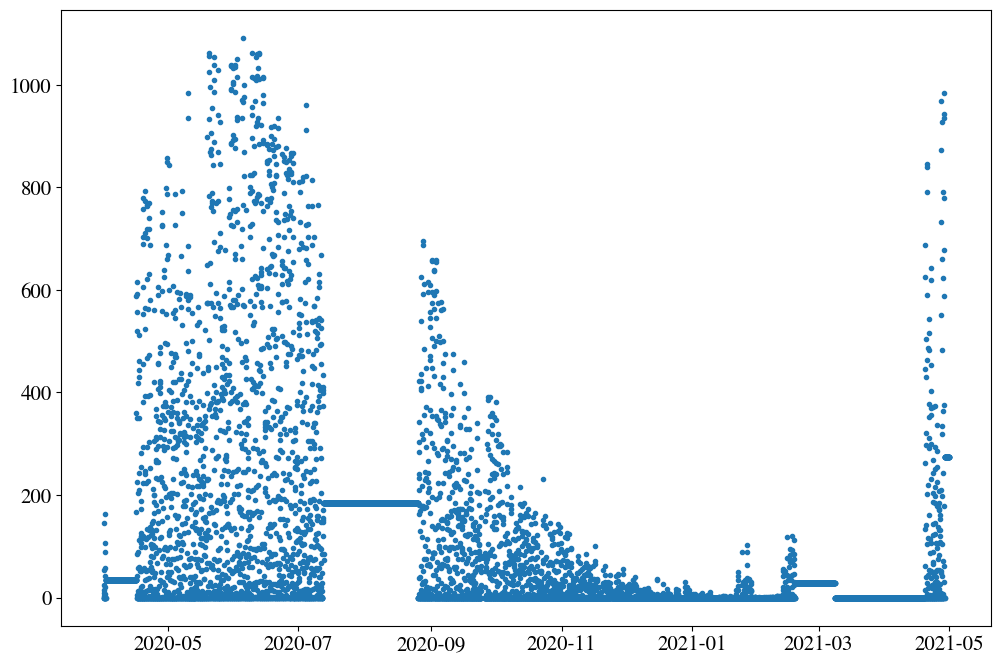

In [17]:
Y_col="pv_measurement"

df_B=df[df["site"]==site_to_num("B")]

filter_all=(df_B["time"] > "2020-4-1")& (df_B["time"] < "2021-5-1")
filter_1=(df_B["time"] > "2021-3-1")& (df_B["time"] < "2021-4-20")

df_B=df_B[filter_all]
plt.plot(df_B["time"], df_B[Y_col], ".")

In [18]:
mask_B = df["site"]==site_to_num("B")
mask = (df[Y_col] == df[Y_col].shift(1)) & df[Y_col]!=0

mask2 = ((df["time"] > "2021-3-1") & (df["time"] < "2021-4-20")) 
print(len(df))
df=df[~(mask & mask_B)]
df=df[~(mask2 & mask_B)]
print(len(df))

92951
88684


/tmp/ipykernel_1305/4221103035.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df[~(mask2 & mask_B)]


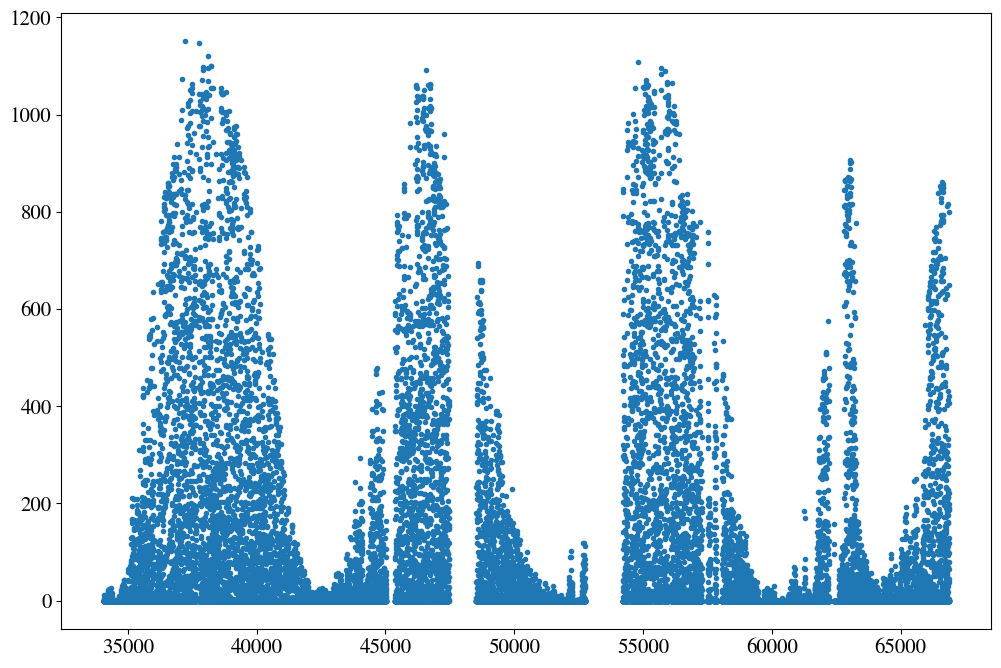

In [19]:
plt.plot(df[df["site"]==site_to_num("B")][Y_col], ".")

# Feature engineering

This part is the main feature engineering. As of right now, a new feature must be added two places. First to df, then to dataframes[location]["X_test_estimated"], in the loop below

In [20]:
month_mapping = {
    1 : 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 6,
    7: 7,
    8: 6,
    9: 5,
    10: 4,
    11: 3,
    12: 2
}

In [21]:
def add_features(df):
    df["month"] = df["time"].dt.month
    df["day"] = df["time"].dt.day
    df["hour"] = df["time"].dt.hour
    df["date_calc"]
    df["date_calc"]= df["date_calc"].fillna(df["time"])
    df["date_difference"] = df["time"]-df["date_calc"]

    df["date_difference"] = df["date_difference"] / pd.Timedelta(hours=1)
    df["is_estimated"] = df["date_difference"].apply(lambda x : int(x > 0))

    df["normal_radiation"] = np.sin(df["sun_elevation:d"] * np.pi / 180) * df["direct_rad:W"]
    df['direct_rad_cloud_interaction'] = df['direct_rad:W'] * df['effective_cloud_cover:p']

    df['sun_elevation_month_interaction'] = df['sun_elevation:d'] * df['month'].map(month_mapping)

    df['elevation_cloud_interaction'] = df['sun_elevation:d'] * df['effective_cloud_cover:p']

    df['cos_elevation'] = np.cos(np.radians(90 - df['sun_elevation:d']))
    df['sun_elevation_squared'] = df['sun_elevation:d'] ** 2
    df['elevation_month_interaction'] = df['sun_elevation:d'] * df['month'].map(month_mapping)

    df["is_midday"] = df["hour"].apply(lambda x : int(abs(x - 12) < 2))

    sin_cos_cols = {"month": 12, "day": 30, "hour": 24}

    for col, period in sin_cos_cols.items():
        df[f"{col}_sin"] = np.sin(df[col] * 2* np.pi / period)
        df[f"{col}_cos"] = np.cos(df[col] * 2* np.pi / period)

    return df

In [22]:
df = add_features(df)
df

## Remove features

This part removes features. It can be done in a few ways

- As a column name: In order to remove a feature by column name, add the name to the list "remove_cols". 
- As a keyword: If you want to remove all features with a specific keyword, add it to the list "remove_words"

This part also generates Y_col, which is used several places as the name of the column we are trying to predict, and X_cols, the list of columns we use to predict Y_col

In [23]:
list(df.columns)

['index',
 'time',
 'pv_measurement',
 'time1',
 'time2',
 'time3',
 'absolute_humidity_2m:gm3',
 'air_density_2m:kgm3',
 'ceiling_height_agl:m',
 'clear_sky_energy_1h:J',
 'clear_sky_rad:W',
 'cloud_base_agl:m',
 'dew_or_rime:idx',
 'dew_point_2m:K',
 'diffuse_rad:W',
 'diffuse_rad_1h:J',
 'direct_rad:W',
 'direct_rad_1h:J',
 'effective_cloud_cover:p',
 'elevation:m',
 'fresh_snow_12h:cm',
 'fresh_snow_1h:cm',
 'fresh_snow_24h:cm',
 'fresh_snow_3h:cm',
 'fresh_snow_6h:cm',
 'is_day:idx',
 'is_in_shadow:idx',
 'msl_pressure:hPa',
 'precip_5min:mm',
 'precip_type_5min:idx',
 'pressure_100m:hPa',
 'pressure_50m:hPa',
 'prob_rime:p',
 'rain_water:kgm2',
 'relative_humidity_1000hPa:p',
 'sfc_pressure:hPa',
 'snow_density:kgm3',
 'snow_depth:cm',
 'snow_drift:idx',
 'snow_melt_10min:mm',
 'snow_water:kgm2',
 'sun_azimuth:d',
 'sun_elevation:d',
 'super_cooled_liquid_water:kgm2',
 't_1000hPa:K',
 'total_cloud_cover:p',
 'visibility:m',
 'wind_speed_10m:ms',
 'wind_speed_u_10m:ms',
 'wind_spe

In [24]:
not_X_cols=["time", "pv_measurement", "date_forecast", "date_calc", "index", "time1", "time2", "time3"]
df.columns
X_cols=[]

for col in df.columns:
    if col not in not_X_cols:
        X_cols.append(col)

Y_col="pv_measurement"

X_cols_new = []

remove_non_rolling = [col for col in non_rolling_cols if col != "site"]

remove_cols= [] # <--- Add columns to remove here

remove_words = [] # <-- Add keywords to remove here

# "snow", "wind", "pressure"


for col in X_cols:
    for word in remove_words:
        if word in col:
            remove_cols.append(col)

for col in X_cols:
    if not col in remove_cols:
        X_cols_new.append(col)
    

X_cols = X_cols_new




The next part is just to check the number of features, making sure its not to insane

In [25]:
X_cols.__len__()

200

# Categorical cols

Here, I generate the categorical cols, which are the columns which has a discrete number of possible values

In [26]:
categorical_cols = []
self_added_categorical = ["site", "elevation:m", "is_estimated", "is_midday"]

for index, col in enumerate(X_cols):
    if col in self_added_categorical:
        categorical_cols.append(col)
    if ":" not in col:
        continue
    if "idx" in col:
        categorical_cols.append(col)


print(categorical_cols)

['dew_or_rime:idx', 'elevation:m', 'is_day:idx', 'is_in_shadow:idx', 'precip_type_5min:idx', 'snow_drift:idx', 'site', 'dew_or_rime:idx1', 'is_day:idx1', 'is_in_shadow:idx1', 'precip_type_5min:idx1', 'snow_drift:idx1', 'dew_or_rime:idx2', 'is_day:idx2', 'is_in_shadow:idx2', 'precip_type_5min:idx2', 'snow_drift:idx2', 'dew_or_rime:idx3', 'is_day:idx3', 'is_in_shadow:idx3', 'precip_type_5min:idx3', 'snow_drift:idx3', 'is_estimated', 'is_midday']


In [27]:
for col in categorical_cols:
    df[col]=df[col].astype(int)

# Generating X and Y

In [28]:
X = df[X_cols]
Y = df[Y_col]

# Model

# Catboost KFolds

In [30]:
n_splits = 5

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

model = CatBoostRegressor(iterations=1e4, cat_features=categorical_cols, loss_function="LogCosh")

In [31]:
fold_models = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_cols)
    test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_cols)
    
    model.fit(train_pool, eval_set=test_pool, use_best_model=True)
    
    fold_models.append(model.copy())
    
    predictions = model.predict(test_pool)
    fold_rmse = mean_absolute_error(predictions, y_test)
    print(f"MAE for fold: {fold_rmse}")

0:	learn: 289.1817610	test: 293.2336160	best: 293.2336160 (0)	total: 276ms	remaining: 46m 3s
1:	learn: 283.3783458	test: 287.3763385	best: 287.3763385 (1)	total: 544ms	remaining: 45m 20s
2:	learn: 277.4217592	test: 281.4156482	best: 281.4156482 (2)	total: 778ms	remaining: 43m 11s
3:	learn: 271.7891692	test: 275.7080337	best: 275.7080337 (3)	total: 997ms	remaining: 41m 32s
4:	learn: 266.3039142	test: 270.2524989	best: 270.2524989 (4)	total: 1.24s	remaining: 41m 11s
5:	learn: 262.9210910	test: 266.8762711	best: 266.8762711 (5)	total: 1.44s	remaining: 39m 53s
6:	learn: 257.2954366	test: 261.2717418	best: 261.2717418 (6)	total: 1.67s	remaining: 39m 46s
7:	learn: 252.2195952	test: 256.2112790	best: 256.2112790 (7)	total: 1.9s	remaining: 39m 28s
8:	learn: 246.5047014	test: 250.5554258	best: 250.5554258 (8)	total: 2.1s	remaining: 38m 51s
9:	learn: 240.6679381	test: 244.6753950	best: 244.6753950 (9)	total: 2.29s	remaining: 38m 7s
10:	learn: 235.0253142	test: 239.0242112	best: 239.0242112 (10)	

/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


MAE for fold: 77.61339419103078
0:	learn: 293.6846594	test: 286.0020803	best: 286.0020803 (0)	total: 152ms	remaining: 25m 20s
1:	learn: 287.2507290	test: 279.7671964	best: 279.7671964 (1)	total: 301ms	remaining: 25m 4s
2:	learn: 281.6701567	test: 274.3214529	best: 274.3214529 (2)	total: 470ms	remaining: 26m 5s
3:	learn: 276.6476658	test: 269.4677929	best: 269.4677929 (3)	total: 625ms	remaining: 26m
4:	learn: 271.0876512	test: 263.9578935	best: 263.9578935 (4)	total: 784ms	remaining: 26m 6s
5:	learn: 264.8717972	test: 257.8379096	best: 257.8379096 (5)	total: 939ms	remaining: 26m 3s
6:	learn: 259.8988559	test: 252.9882377	best: 252.9882377 (6)	total: 1.11s	remaining: 26m 22s
7:	learn: 255.0072699	test: 248.1249338	best: 248.1249338 (7)	total: 1.26s	remaining: 26m 10s
8:	learn: 248.8481623	test: 242.0994903	best: 242.0994903 (8)	total: 1.42s	remaining: 26m 18s
9:	learn: 243.8001738	test: 237.1304014	best: 237.1304014 (9)	total: 1.57s	remaining: 26m 4s
10:	learn: 238.0015609	test: 231.4787

/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


MAE for fold: 75.30956192959319
0:	learn: 294.0161325	test: 285.4381061	best: 285.4381061 (0)	total: 164ms	remaining: 27m 20s
1:	learn: 288.3085001	test: 279.8644779	best: 279.8644779 (1)	total: 320ms	remaining: 26m 38s
2:	learn: 282.4269018	test: 274.1418589	best: 274.1418589 (2)	total: 495ms	remaining: 27m 29s
3:	learn: 275.3921726	test: 267.3585906	best: 267.3585906 (3)	total: 662ms	remaining: 27m 34s
4:	learn: 269.9560314	test: 262.0484609	best: 262.0484609 (4)	total: 811ms	remaining: 27m
5:	learn: 263.7706084	test: 256.1099167	best: 256.1099167 (5)	total: 953ms	remaining: 26m 26s
6:	learn: 257.8878128	test: 250.3900627	best: 250.3900627 (6)	total: 1.11s	remaining: 26m 20s
7:	learn: 253.1425579	test: 245.8184402	best: 245.8184402 (7)	total: 1.29s	remaining: 26m 47s
8:	learn: 248.1690844	test: 241.0255426	best: 241.0255426 (8)	total: 1.44s	remaining: 26m 40s
9:	learn: 242.5064150	test: 235.6130639	best: 235.6130639 (9)	total: 1.6s	remaining: 26m 38s
10:	learn: 240.0618932	test: 233.

/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


MAE for fold: 77.10364401255146
0:	learn: 291.1170647	test: 289.1446109	best: 289.1446109 (0)	total: 142ms	remaining: 23m 37s
1:	learn: 285.2845047	test: 283.4275370	best: 283.4275370 (1)	total: 288ms	remaining: 23m 59s
2:	learn: 281.5733141	test: 279.7349620	best: 279.7349620 (2)	total: 442ms	remaining: 24m 34s
3:	learn: 275.8381832	test: 273.9869101	best: 273.9869101 (3)	total: 609ms	remaining: 25m 21s
4:	learn: 270.9618733	test: 269.0658444	best: 269.0658444 (4)	total: 754ms	remaining: 25m 6s
5:	learn: 264.9082720	test: 262.9910070	best: 262.9910070 (5)	total: 901ms	remaining: 25m 1s
6:	learn: 261.7905437	test: 259.8613628	best: 259.8613628 (6)	total: 1.06s	remaining: 25m 13s
7:	learn: 256.2045159	test: 254.2095586	best: 254.2095586 (7)	total: 1.22s	remaining: 25m 17s
8:	learn: 250.3644363	test: 248.3139292	best: 248.3139292 (8)	total: 1.37s	remaining: 25m 24s
9:	learn: 245.0715094	test: 242.9846057	best: 242.9846057 (9)	total: 1.55s	remaining: 25m 50s
10:	learn: 240.0071123	test: 2

/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


MAE for fold: 76.96482890506573
0:	learn: 289.8095287	test: 304.0909867	best: 304.0909867 (0)	total: 183ms	remaining: 30m 28s
1:	learn: 283.6659965	test: 297.6468202	best: 297.6468202 (1)	total: 337ms	remaining: 28m 5s
2:	learn: 277.0684392	test: 290.7199564	best: 290.7199564 (2)	total: 491ms	remaining: 27m 15s
3:	learn: 272.0953271	test: 285.5000590	best: 285.5000590 (3)	total: 631ms	remaining: 26m 17s
4:	learn: 266.2873298	test: 279.4263795	best: 279.4263795 (4)	total: 789ms	remaining: 26m 17s
5:	learn: 260.0409139	test: 272.8196106	best: 272.8196106 (5)	total: 950ms	remaining: 26m 23s
6:	learn: 255.6483168	test: 268.2124422	best: 268.2124422 (6)	total: 1.1s	remaining: 26m 12s
7:	learn: 249.5683747	test: 261.7926249	best: 261.7926249 (7)	total: 1.25s	remaining: 26m 4s
8:	learn: 243.9135223	test: 255.8134460	best: 255.8134460 (8)	total: 1.4s	remaining: 25m 58s
9:	learn: 238.3262815	test: 249.8963404	best: 249.8963404 (9)	total: 1.55s	remaining: 25m 49s
10:	learn: 235.5155667	test: 247

/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [32]:

def predict_fold_models(fold_models, X):

    predictions = np.zeros((X.shape[0], len(fold_models)))

    for i, model in enumerate(fold_models):
        predictions[:, i] = model.predict(X)

    y_array = np.mean(predictions, axis=1)
    
    y_out = np.zeros(len(y_array))

    for i, y in enumerate(y_array):
        if y < 0.05:
            y_out[i] = 0
        else: 
            y_out[i] = y
    return y_out

y_test = predict_fold_models(fold_models, X)

In [33]:
mean_absolute_error(y_test, Y)

/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


65.72560622409621

(-5000.0, 5000.0)

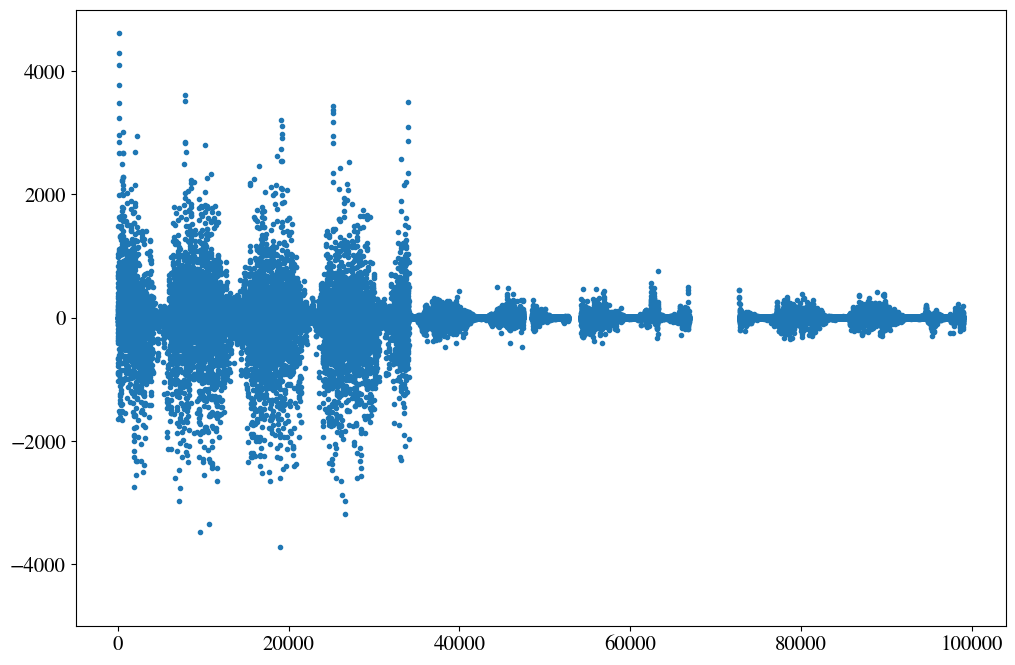

In [34]:
lim=5e3
plt.plot((y_test - Y), ".")
plt.ylim((-lim, lim))

These plots are done in order to evaluate the model. We see that most of the MAE comes from A due to the higher pv_measurement values. 

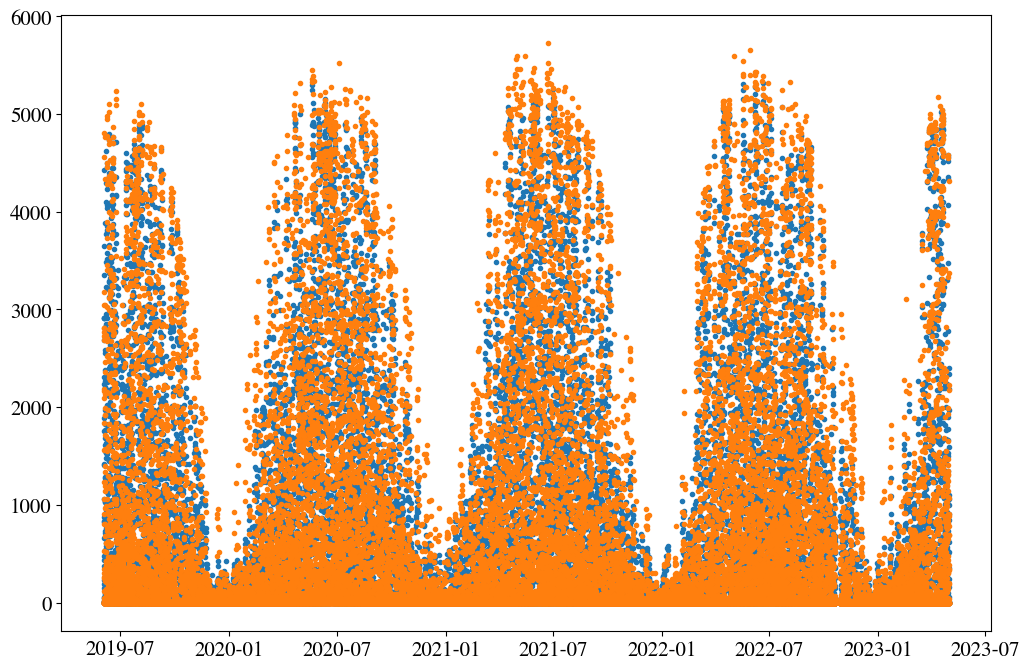

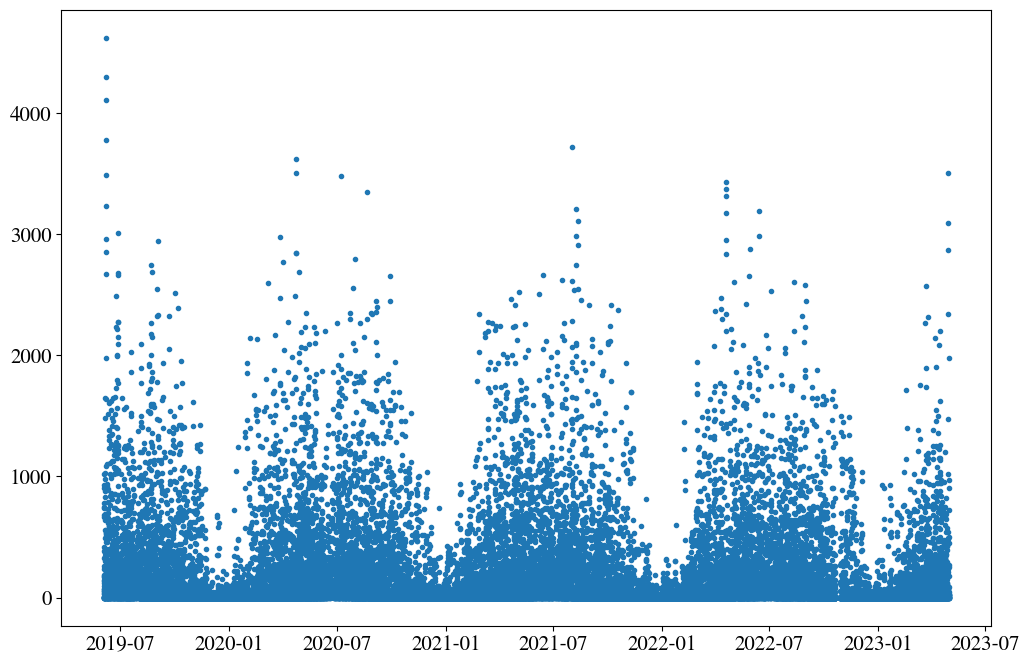

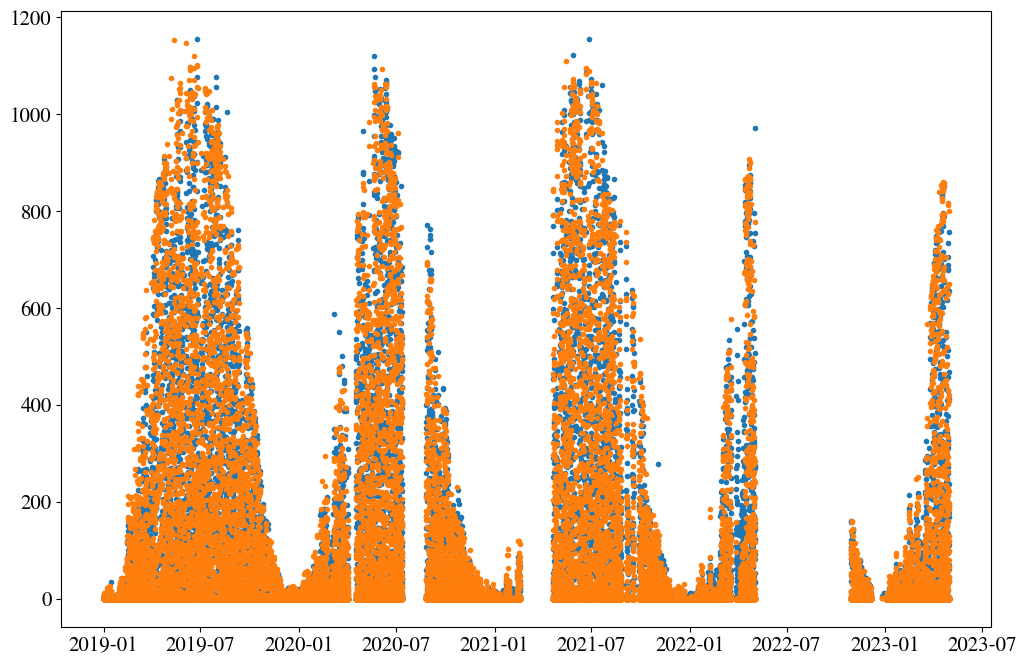

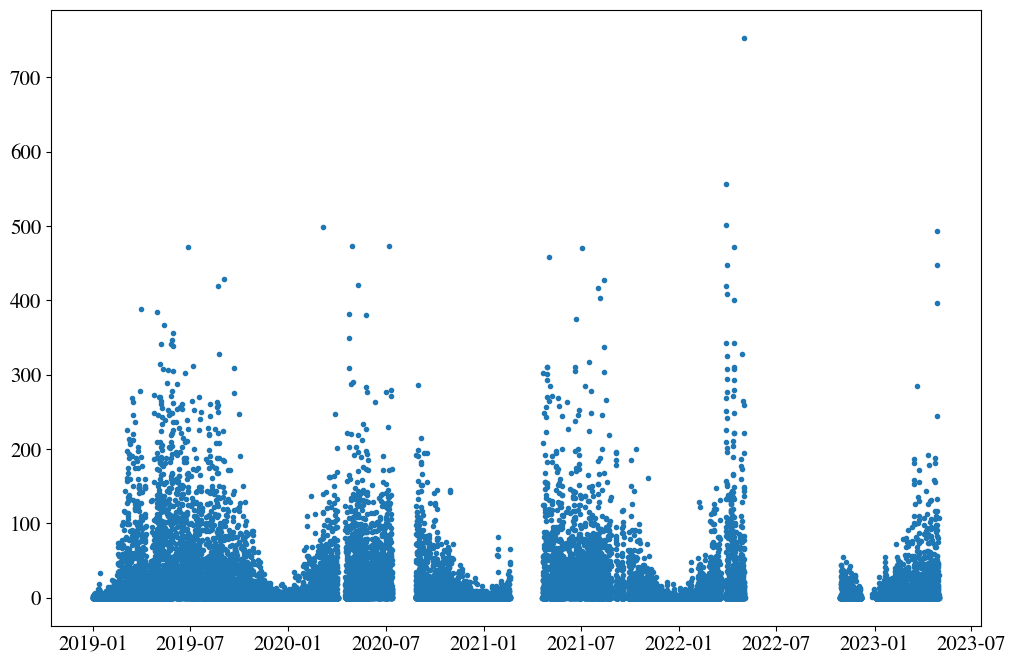

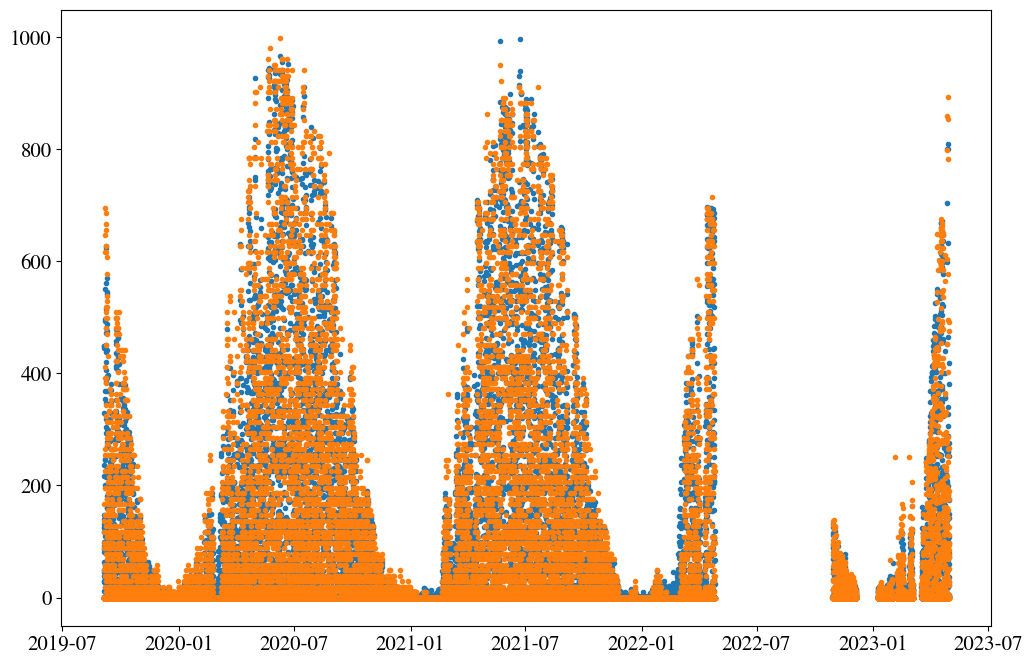

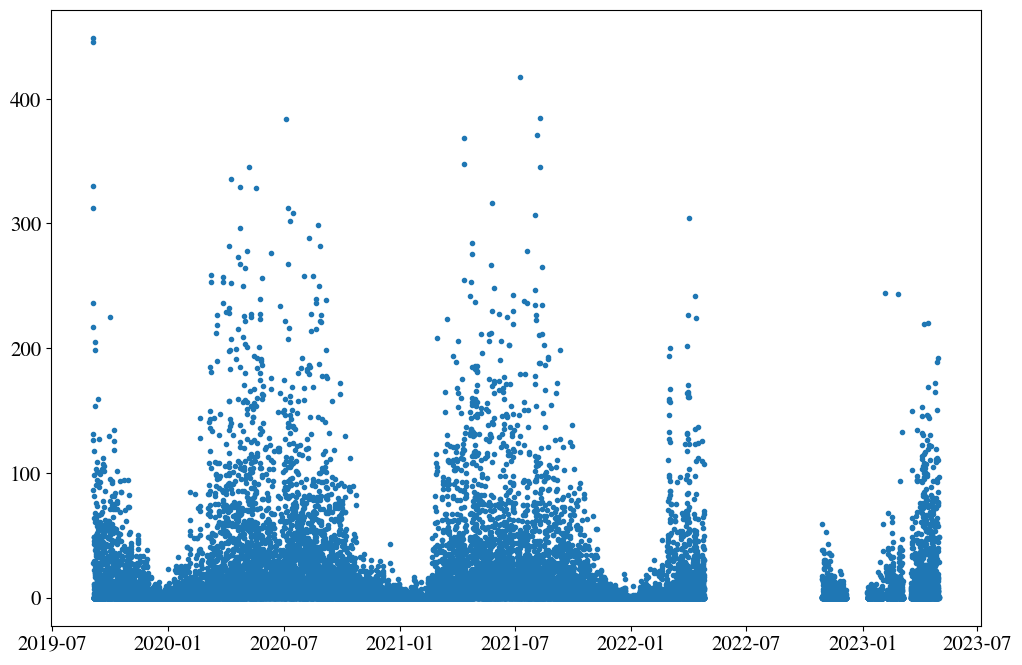

In [35]:
for site in range(1, 4):
    df_here=df
    df_site=df[df["site"]==site]
    y_here = predict_fold_models(fold_models, df_site[X_cols])
    plt.plot(df_site["time"], y_here, ".")
    plt.plot(df_site["time"], df_site[Y_col], ".")
    plt.show()

    plt.plot(df_site["time"], abs(df_site[Y_col] - y_here), ".")
    plt.show()


# Submit predictions

In [36]:
os.listdir("../data/")
path_test="../data/test.csv"
df_final = pd.read_csv(path_test)
df_final["time"] = pd.to_datetime(df_final["time"])

df_final

id                time  prediction location
0        0 2023-05-01 00:00:00           0        A
1        1 2023-05-01 01:00:00           0        A
2        2 2023-05-01 02:00:00           0        A
3        3 2023-05-01 03:00:00           0        A
4        4 2023-05-01 04:00:00           0        A
...    ...                 ...         ...      ...
2155  2155 2023-07-03 19:00:00           0        C
2156  2156 2023-07-03 20:00:00           0        C
2157  2157 2023-07-03 21:00:00           0        C
2158  2158 2023-07-03 22:00:00           0        C
2159  2159 2023-07-03 23:00:00           0        C

[2160 rows x 4 columns]

In [37]:
def pred_location(df_final, location, model, auto_ml=False, seperate_model=False, kfolds_model=False):
    
    column = "X_test_estimated"
    df_Y = df_final[df_final["location"]==location]
    df_Y = df_Y[df_Y["time"].isin(dataframes[location][column]["date_forecast"])].reset_index()

    df_to_predict = feature(df_Y, dataframes[location][column])
    df_to_predict["site"] = df_to_predict["location"].apply(site_to_num)
    

    df_to_predict = add_features(df_to_predict)
    
    for col in categorical_cols:
        df_to_predict[col]=df_to_predict[col].astype(int)
    

    if kfolds_model:
        preds = predict_fold_models(model, df_to_predict[X_cols])

    else:
        preds = model.predict(df_to_predict[X_cols])


    return preds, df_to_predict



The only thing you need to consider in this section is the model. If you have used auto_ml or the seperated models you must also switch those variables.

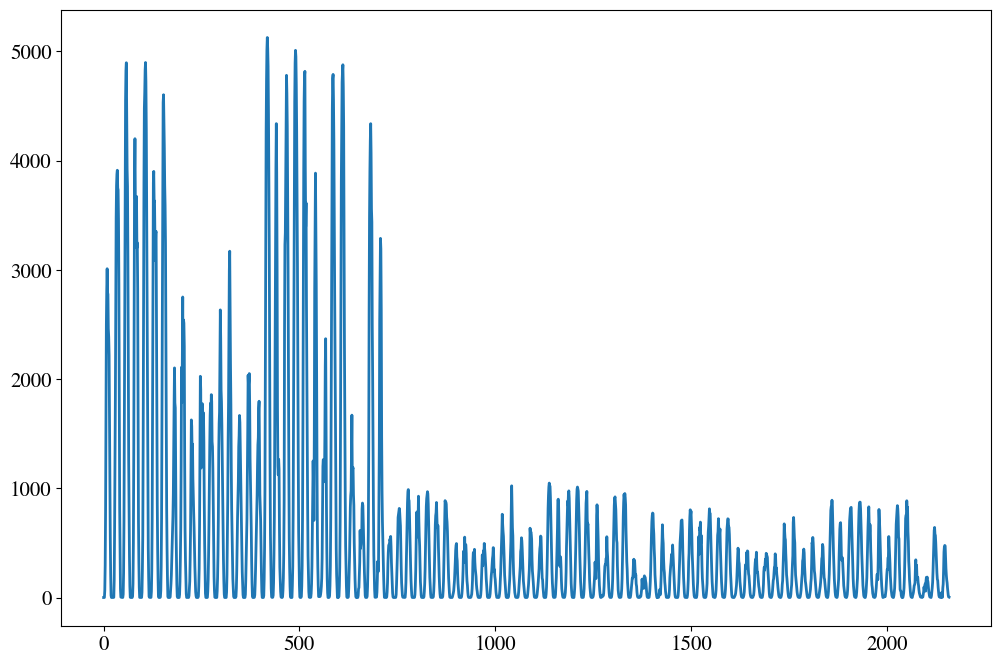

In [38]:
model=fold_models
auto_ml=False
seperate_model_param=False
kfolds_model=True

preds_A, df_A = pred_location(df_final, "A", model, auto_ml=auto_ml, seperate_model=seperate_model_param, kfolds_model=kfolds_model)
preds_B, df_B = pred_location(df_final, "B", model, auto_ml=auto_ml, seperate_model=seperate_model_param, kfolds_model=kfolds_model)
preds_C, df_C = pred_location(df_final, "C", model, auto_ml=auto_ml, seperate_model=seperate_model_param, kfolds_model=kfolds_model)


df_A["prediction"] = preds_A
df_B["prediction"] = preds_B
df_C["prediction"] = preds_C

df_final_final = pd.concat([df_A, df_B, df_C], ignore_index=True)

plt.plot(df_final_final["id"], df_final_final["prediction"])

In [39]:
df_final_final.set_index("id")

file_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

df_final_final[["id", "prediction"]].to_csv(f"../predictions/{file_name}.csv", index=False)
# df_final_final

In [4]:
current_submission = df_final_final[["id", "prediction"]]

## **Autogluon Model**

In [21]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from autogluon.tabular import TabularPredictor

/Users/aaryan/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Reading the data**

In [ ]:
# Create a dictionary to hold the data for each site
data_dict = {'A': {}, 'B': {}, 'C': {}}

# List of file types you want to read
file_types = ['X_train_observed', 'X_train_estimated', "train_targets"]

# Base directory path
path = "./Data/"

# Loop through each site and file type to read and transform the data
for site in data_dict.keys():
    for f_type in file_types:
        file_path = f"{path}{site}/{f_type}.parquet"
        data = pd.read_parquet(file_path)
        
        if 'date_forecast' in data.columns:
            data.set_index('date_forecast', inplace=True)  # Assuming date_forecast is the index
            data.index = pd.to_datetime(data.index)
        
        data_dict[site][f_type] = data

    # Resample observed and estimated data to hourly
    observed_hourly = data_dict[site]['X_train_observed'].resample('H').mean()
    estimated_hourly = data_dict[site]['X_train_estimated'].resample('H').mean()
    
    # Prepare the targets
    train_targets = data_dict[site]['train_targets']
    train_targets.set_index('time', inplace=True)
    train_targets.index = pd.to_datetime(train_targets.index)
    
# Features for the OBSERVED data
    # Normalize features
    max_distance = 12
    observed_hourly['distance_from_11'] = abs(observed_hourly.index.hour - 11)
    observed_hourly['normalized_distance_from_11'] = 1 - (observed_hourly['distance_from_11'] / max_distance)
    
    # Add "is_estimated" feature and set it to 0 for all rows
    observed_hourly['is_estimated'] = 0
    
    # Remove features
    drop_features_O = ["distance_from_11"]
    observed_hourly = observed_hourly.drop(drop_features_O, axis=1)
    
# Features for the ESTIMATED data
    # Normalize features
    estimated_hourly['distance_from_11'] = abs(estimated_hourly.index.hour - 11)
    estimated_hourly ['normalized_distance_from_11'] = 1 - (estimated_hourly['distance_from_11'] / max_distance)

    # Remove features
    drop_features_E = ["distance_from_11"]
    estimated_hourly = estimated_hourly.drop(drop_features_E, axis=1)

    # Add "is_estimated" feature and set it to 1 for all rows
    estimated_hourly['is_estimated'] = 1
    

    
    # Merge observed and estimated data with train_targets
    observed_hourly = observed_hourly.join(train_targets, how='inner')
    estimated_hourly = estimated_hourly.join(train_targets, how='inner')
    
    # Store the processed data in separate DataFrames
    data_dict[site]['observed_hourly'] = observed_hourly
    data_dict[site]['estimated_hourly'] = estimated_hourly

# Access the processed data for each site
df_A_O = data_dict['A']['observed_hourly']
df_A_E = data_dict['A']['estimated_hourly']
df_B_O = data_dict['B']['observed_hourly']
df_B_E = data_dict['B']['estimated_hourly']
df_C_O = data_dict['C']['observed_hourly']
df_C_E = data_dict['C']['estimated_hourly']

df_A = pd.concat([df_A_O, df_A_E])
df_B = pd.concat([df_B_O, df_B_E])
df_C = pd.concat([df_C_O, df_C_E])

### **Preprocessing**

**Handling the duplicate values in B**

In [ ]:
def remove_consecutive_duplicates_B(df, column_name, consecutive_count=10):
    mask = (df[column_name] != 0)
    for i in range(1, consecutive_count):
        mask = mask & (df[column_name] == df[column_name].shift(-i))
        if i == 1:
            print("Consecutive Rows with Non-Zero Values:")
            print(df[mask][column_name])
    mask2 = (df.index > "2021-03-08") & (df.index < "2021-04-20")
    df_filtered = df[~mask2 & ~mask]
    return df_filtered

In [ ]:
df_B = remove_consecutive_duplicates_B(df_B, "pv_measurement")
df_B.shape

**Handling consecutive duplicate values in A and C**

In [ ]:
def remove_consecutive_duplicates_AC(df, column_name, consecutive_count=10):
    mask = (df[column_name] != 0)
    for i in range(1, consecutive_count):
        mask = mask & (df[column_name] == df[column_name].shift(-i))
        if i == 1:
            print("Consecutive Rows with Non-Zero Values:")
            print(df[mask][column_name])
    df_filtered = df[~mask]
    return df_filtered

In [ ]:
df_A = remove_consecutive_duplicates_AC(df_A, "pv_measurement", 10)
df_C = remove_consecutive_duplicates_AC(df_C, "pv_measurement", 6)
print(df_A.shape)
print(df_C.shape)

**Only remove pv NaNs**

In [ ]:
# Drop rows where only pv_measurement column is NaN in DataFrame A
df_A.dropna(subset=['pv_measurement'], how='all', inplace=True)

# Drop rows where only pv_measurement column is NaN in DataFrame B
df_B.dropna(subset=['pv_measurement'], how='all', inplace=True)

# Drop rows where only pv_measurement column is NaN in DataFrame C
df_C.dropna(subset=['pv_measurement'], how='all', inplace=True)

# Reset index after dropping rows
df_A.reset_index(drop=True, inplace=True)
df_B.reset_index(drop=True, inplace=True)
df_C.reset_index(drop=True, inplace=True)

# Print updated shapes of the DataFrames
print("Updated shape of DataFrame A:", df_A.shape)
print("Updated shape of DataFrame B:", df_B.shape)
print("Updated shape of DataFrame C:", df_C.shape)

## **Autogluon**

**Split into training and tuning data for Autoglon**

In [ ]:
# Separate tuning and training data for each site

# Select the last rows for tuning data for each site
tuning_data_A = df_A[df_A['is_estimated'] == 1].tail(1178)
tuning_data_B = df_B[df_B['is_estimated'] == 1].tail(823)
tuning_data_C = df_C[df_C['is_estimated'] == 1].tail(771)

train_data_A = df_A[(~df_A.index.isin(tuning_data_A.index))]
train_data_B = df_B[(~df_B.index.isin(tuning_data_B.index))]
train_data_C = df_C[(~df_C.index.isin(tuning_data_C.index))]

In [ ]:
### Train AutoGluon models for each site

predictor_A = TabularPredictor(label='pv_measurement', eval_metric="mean_absolute_error", path='Autogluon/A/').fit(train_data = train_data_A, tuning_data = tuning_data_A, use_bag_holdout=True, num_bag_folds = 8, num_stack_levels=0, time_limit=600, presets="best_quality", excluded_model_types=['KNN'])
predictor_B = TabularPredictor(label='pv_measurement',eval_metric="mean_absolute_error", path='Autogluon/B/').fit(train_data = train_data_B, tuning_data = tuning_data_B, use_bag_holdout=True, num_bag_folds = 8, num_stack_levels=0, time_limit=600, presets="best_quality", excluded_model_types=['KNN'])
predictor_C = TabularPredictor(label='pv_measurement', eval_metric="mean_absolute_error"path='Autogluon/C/').fit(train_data = train_data_C, tuning_data = tuning_data_C, use_bag_holdout=True, num_bag_folds = 8, num_stack_levels=0, time_limit=600,presets="best_quality", excluded_model_types=['KNN'])

# **Processing the test data**

In [ ]:
# Initialize empty DataFrames for each site
X_test_A = pd.DataFrame()
X_test_B = pd.DataFrame()
X_test_C = pd.DataFrame()

sites = ['A', 'B', 'C']

# Load and process data for each site
for site in sites:
    # Load data
    file_path = os.path.join(path, f"{site}/X_test_estimated.parquet")
    data = pd.read_parquet(file_path)
    
    # Convert 'date_forecast' to DateTime
    data['date_forecast'] = pd.to_datetime(data['date_forecast'])
    
    # Set is_estimated to 1 for all rows
    data['is_estimated'] = 1
    
    # Set 'date_forecast' column as the index
    data = data.set_index('date_forecast')

    # Group by hour and take mean for each group, keeping 'date_forecast' as a regular column
    data = data.groupby(data.index.floor('H')).mean()

    # Reset index to retain 'date_forecast' as a column
    data.reset_index(inplace=True)
    
    # Calculate the absolute distance from 11 o'clock for each timestamp
    max_distance = 12
    data['distance_from_11'] = abs(data['date_forecast'].dt.hour - 11)
    data['normalized_distance_from_11'] = 1 - (data['distance_from_11'] / max_distance)
    
    # Drop unnecessary columns
    features_to_drop = ["distance_from_11"]
    data = data.drop(features_to_drop, axis=1)
    
    # Sort columns alphabetically
    data = data.reindex(sorted(data.columns), axis=1)
    
    # Add processed data to respective variables based on the site
    if site == 'A':
        X_pred_A = data
    elif site == 'B':
        X_pred_B = data
    elif site == 'C':
        X_pred_C = data

    print(f"Processed data for Site {site}: {X_pred_A.shape}")

# Reset index for X_test_A
X_pred_A.reset_index(drop=True, inplace=True)

# Reset index for X_test_B
X_pred_B.reset_index(drop=True, inplace=True)

# Reset index for X_test_C
X_pred_C.reset_index(drop=True, inplace=True)    

# **Predictions**

In [ ]:
predictor_A = TabularPredictor.load("AutogluonModels/A/")
predictor_B = TabularPredictor.load("AutogluonModels/B/")
predictor_C = TabularPredictor.load("AutogluonModels/C/")

# Apply the preprocessing pipeline on test data for site A
X_test_A_preprocessed = predictor_A.predict(X_pred_A)

# Apply the preprocessing pipeline on test data for site B
X_test_B_preprocessed = predictor_B.predict(X_pred_B)

# Apply the preprocessing pipeline on test data for site C
X_test_C_preprocessed = predictor_C.predict(X_pred_C)

In [ ]:
# Now, you can make predictions on the preprocessed test data
y_preds_A = X_test_A_preprocessed
y_preds_B = X_test_B_preprocessed
y_preds_C = X_test_C_preprocessed

 **Apply threshold and concatenate predictions**

In [ ]:
threshold = 0.05
y_preds_A_df = pd.DataFrame({'id': X_test_A_preprocessed.index, 'prediction': y_preds_A.apply(lambda x: 0 if x < threshold else x)})
y_preds_B_df = pd.DataFrame({'id': X_test_B_preprocessed.index, 'prediction': y_preds_B.apply(lambda x: 0 if x < threshold else x)})
y_preds_C_df = pd.DataFrame({'id': X_test_C_preprocessed.index, 'prediction': y_preds_C.apply(lambda x: 0 if x < threshold else x)})

# Concatenate the prediction DataFrames
y_preds = pd.concat([y_preds_A_df, y_preds_B_df, y_preds_C_df], ignore_index=True)

y_preds[["prediction"]]

# **Find average with the catboost model**

Our final prediction is an average between the autogluon model and the catboost model

In [ ]:
#Find average of two submissions
new_sub = pd.DataFrame({'id': y_preds.index, 'prediction': ((y_preds["prediction"] + current_submission["prediction"])/2)})

# Identify rows where 'id' corresponds to hours 21 to 01
hours_to_reset = list(range(21, 24)) + list(range(0, 2))

# Set the prediction to 0 for the identified rows
new_sub['prediction'] = new_sub.apply(lambda row: 0 if row['id'] % 24 in hours_to_reset else row['prediction'], axis=1)

new_sub["prediction"] =  new_sub['prediction'].apply(lambda x: 0 if x < 0.05 else x)

new_sub.to_csv("short_notebook_2.csv", index=False)

new_sub["prediction"]